<a href="https://colab.research.google.com/github/adasegroup/ML2023_seminars/blob/master/seminar12/attention_seminar_part1/attention_seminar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attention mechanism from scratch

## Recap

### Embeddings

All text need to be divided into **tokens**. A **token** is a minimal unit of textual information, often a word or part of a word.

To vectorize a token into a numerical vector, you need to get embedding of the token from embedding layer.

Word **embeddings** are representation vectors for words in a lower-dimensional space.

**Embedding layer** is a trainable matrix. TO get embedding of the token you need to take an appropriate row according to token ID.

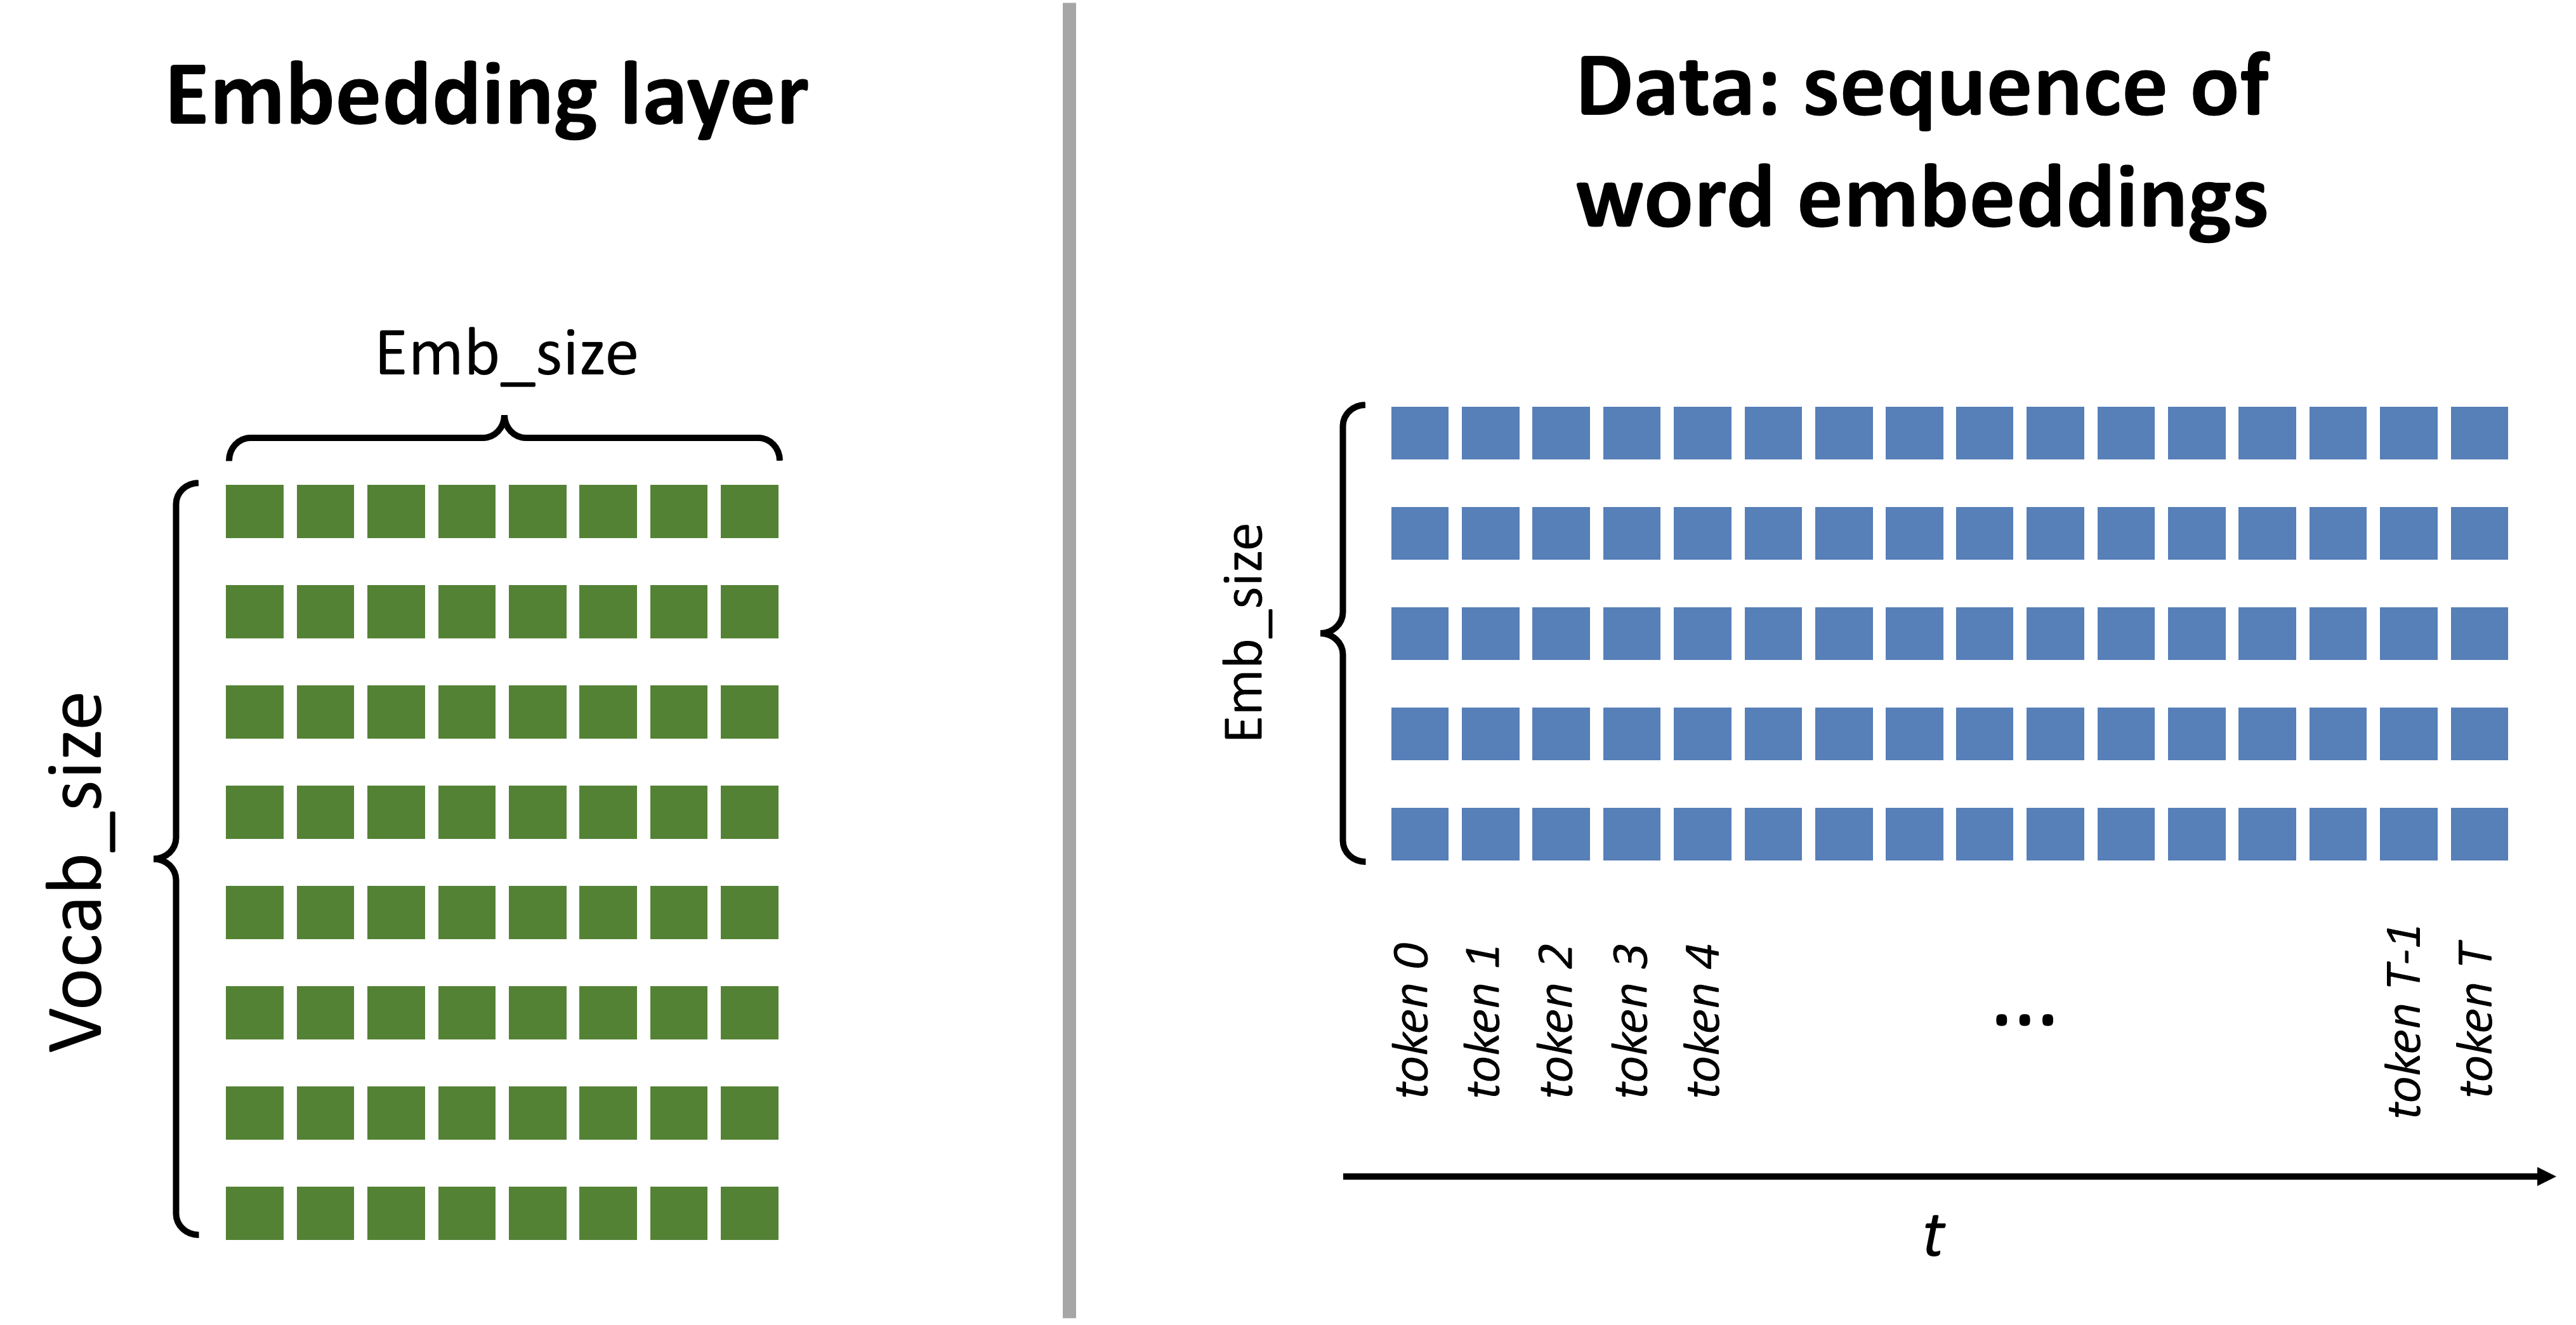

Well trained embeddings can have interesting characteristic. For example, if you find difference between vectors of words "Man" and "Woman", you can get similar vector to difference between vectors "King" and "Queen". It demonstrates that embeddings save relationships between words.

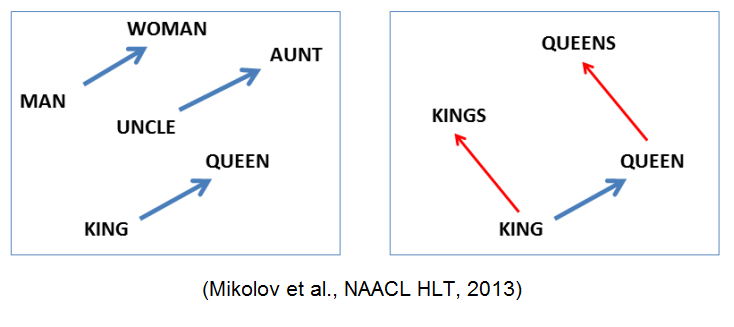

### Key concepts of attention

Attention is based on three core objects **query, key, value**.

Attention principles are very naturals and could be interpreted as:

1. Query - what you want to find (decoder)
2. Key - representation of data (encoder)
3. Value - the importance of the object in data (encoder)

The query is what you want to find in a date, key - represents data for query search, and value is information stored in an object. A natural example could be illustrated in the machine translation task.

![language-model.png](https://raw.githubusercontent.com/zaaabik/msd2021/main/attention_sentence.png)

In this picture, queries from one language have bigger attention for words with the same meaning but in a different language.

### Transformer architecture

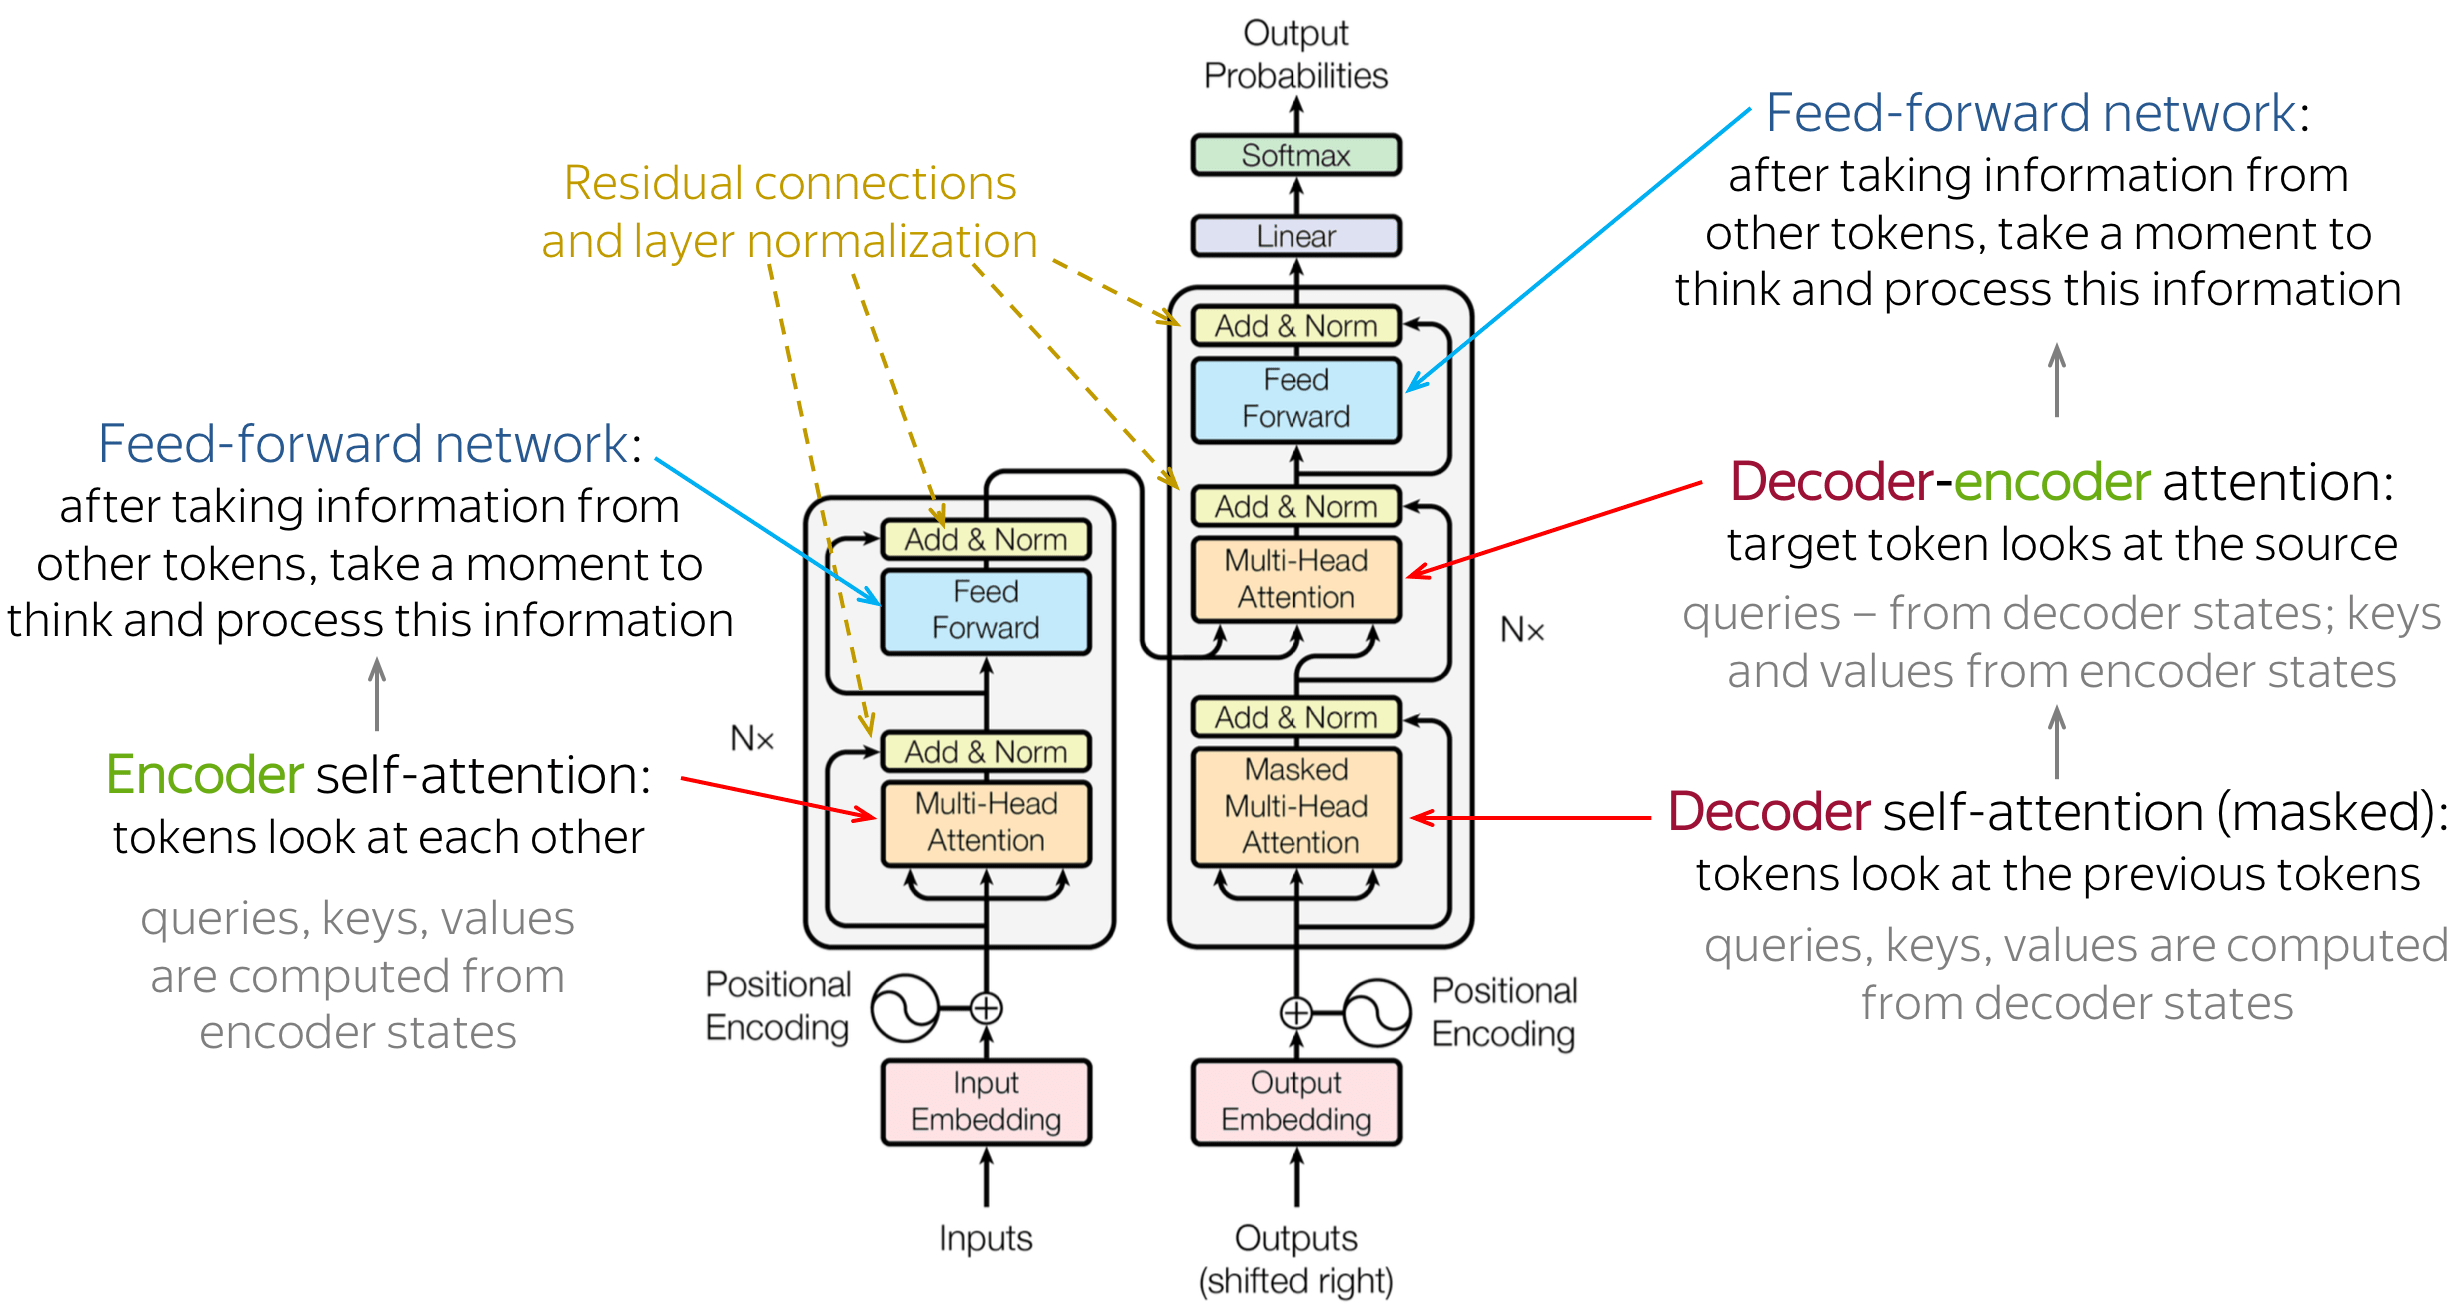

## Lets go into details!



### Similarity coefficient
First of all, we need to compute the similarity coefficient between each query and key.

\begin{align}
 cᵢⱼ = f(qᵢ, kⱼ)
\end{align}
where $c$ is similairty coefficient between $i$-query with $j$ key.

Function $f$ could be an arbitrary function that returns the real number and describes two elements' similarities.

### Attention weights
For each $ q_i $, we compute similarity coefficient with whole keys and obtain vector from $ R^{n} $, where n - number of keys.
\begin{align}
 C_i  = [c_{i 1}, c_{i 2} ... c_{i n}]
\end{align}

One of the problems is that elements in $ C_i $ could be on a different scale. So, we want to map the sum into $(0, 1)$ and interpret elements as a probability. To do it, we use the softmax function:

\begin{align}
a_{ij} = \frac{\text{exp}(c_{i j})}{\sum_n \text{exp}(a_{in})}
\end{align}

\begin{align}
A_i  = softmax(C_i) = softmax([c_{i 1}, c_{i 2} ... c_{i n}])
\end{align}

### Attention matrix
Finally we get an attention matrix, where each row is softmaxed similarity coefficent of one query with all keys.

\begin{align}
A_i  = [
    A_1,\\
    A_2,\\
    ...\\
    A_{n - 1}\\
    A_n]
\end{align}

### Attention output



The output of the attention block is a weighted sum of values.
\begin{align}
 O_k = \sum^n_{i = 1} a_{k i} v_i = A_k V
\end{align}

## Lets code!

In [ ]:
!pip install -U torchdata
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm
!pip install portalocker>=2.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 29.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 20.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Transformer

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

### Similarity coefficient
We should create a function that takes two vectors with the same shape and return a real value. The most straightforward measure is the dot product.

### Dot product attention
The core idea is to use a scaled dot product as a similarity coefficient.

\begin{align}
c  =  \frac{\langle \mathbf{q}, \mathbf{k} \rangle}{\sqrt{d}}
\end{align}
The function takes two vectors with the same dimension $q, k \in R^d$, and compute dot product and device by dimension size. Dividing helps reduce std difference for vectors with different size and make the function more general.

#### task 1.1 Implement similarity function

In [ ]:
torch.manual_seed(0)

d = 256
q = torch.rand(d)
k = torch.rand(d)

def scalar_similarity_coefficient(q, k, d):
    ## TODO write scaled dot product
    return torch.dot(q, k) / np.sqrt(d)

similarity_score = scalar_similarity_coefficient(q, k, d)
assert(
    torch.allclose(similarity_score,
                   torch.tensor(3.854549))
)

But there are many different functions we can use as a score function:


1.   Multilayer Perceptron Attention
\begin{align}
c = \mathbf{v}^T \text{tanh}(\mathbf{W}_k \mathbf{k} + \mathbf{W}_q \mathbf{q}).
\end{align}
2.   Neural network
\begin{align}
c = \text{NN}(q \mathbin\Vert k)
\end{align} where $q \mathbin\Vert k$ - concatenating the key and value in the feature dimension







To compute coefficient for multiple queries and keys efficient, we need to rewrite all in **vectorized form**.

We assume  $q \in R^{b, t, d}$ and $ k \in R^{b, k, d} $ where $b$ - batch size, $t$ and $k$ - number of queries and keys, $d$ - the shape of the data.

PyTorch framework has the function for multiplication elements in a batch manner.

`torch.bnn(tensor1, tensor2)`
, where tensor1 is a $ (b \times n \times m) $ and tensor2 is a $ (b \times m \times p) $ . This function produce matrix multiplication for each object in a batch independent and output has shape $(b \times  n \; x \times p)$

#### task 1.2 Implement similarity function

In [ ]:
## imagine that we have 10 queries and 8 keys and need to construce matrix of cofficent.

torch.manual_seed(0)
d = 64
t,k = 10, 8
batch_size = 3
query = torch.rand(t, d)
query = query.repeat(batch_size, 1, 1)

key = torch.rand(k, d)
key = key.repeat(batch_size, 1, 1)

def compute_coefficient_matrix(query, key, d):
    ## TODO write vectorized scaled dot product
    return query @ key.transpose(-1, -2) / np.sqrt(d)

coefficient_matrix = compute_coefficient_matrix(query, key, d)

second_query = query[0, 2]
third_key = key[0, 3]

assert torch.allclose(coefficient_matrix[0, 2,3], scalar_similarity_coefficient(second_query, third_key, d))
assert torch.allclose(coefficient_matrix[0], coefficient_matrix[1])
assert torch.Size([batch_size, t,k]) == coefficient_matrix.shape

In [ ]:
def slow_non_vector_compute_coefficient_matrix(query, key, d):
    b_s, q_l, _ = query.shape
    _, k_l, _ = key.shape
    out = torch.zeros(b_s, q_l, k_l)

    for b in range(b_s):
        for q in range(q_l):
            for k in range(k_l):
                current_query = query[b, q]
                current_key = key[b, k]
                out[b, q, k] = scalar_similarity_coefficient(current_query, current_key, d)
    return out


In [ ]:
d = 64
t, k = 32, 10
batch_size = 128

query = torch.rand(batch_size, t, d)
key = torch.rand(batch_size, k, d)

In [ ]:
%%time
slow_attention_results = slow_non_vector_compute_coefficient_matrix(query, key, d)

CPU times: user 1.75 s, sys: 7.74 ms, total: 1.76 s
Wall time: 1.95 s


In [ ]:
%%time
fast_attention_result = compute_coefficient_matrix(query, key, d)

CPU times: user 760 µs, sys: 0 ns, total: 760 µs
Wall time: 771 µs


**Using vectorization significant reduce attention computation time.**

In [ ]:
assert torch.allclose(slow_attention_results, fast_attention_result)

After getting the coefficient matrix, we need to transform it into probabilities by applying the softmax function. Each row contains a coefficient between one query and all keys, which should be a probability distribution.

#### task 2. calculate attention matrix efficiently

In [ ]:
## imagine that we have 10 queries and 8 keys and need to construce matrix of cofficent.

torch.manual_seed(2)
d = 64
t,k = 10, 8
batch_size = 3
query = torch.rand(batch_size, t, d)
key = torch.rand(batch_size, k, d)

def compute_attention_matrix(query, key, d):
    coefficient_matrix = compute_coefficient_matrix(query, key, d)
    ## TODO apply softmax
    attention_matrix = torch.softmax(coefficient_matrix, dim=-1)
    return attention_matrix

A = compute_attention_matrix(query, key, d)

assert np.allclose((A.sum(axis=-1) - 1).sum().numpy(), 0, atol=1e-6)
assert torch.all(A >= 0.0)

We could visualize the attention matrix where several rows correspond to the query and column number to the key, and the value shows the attention coefficient between them.

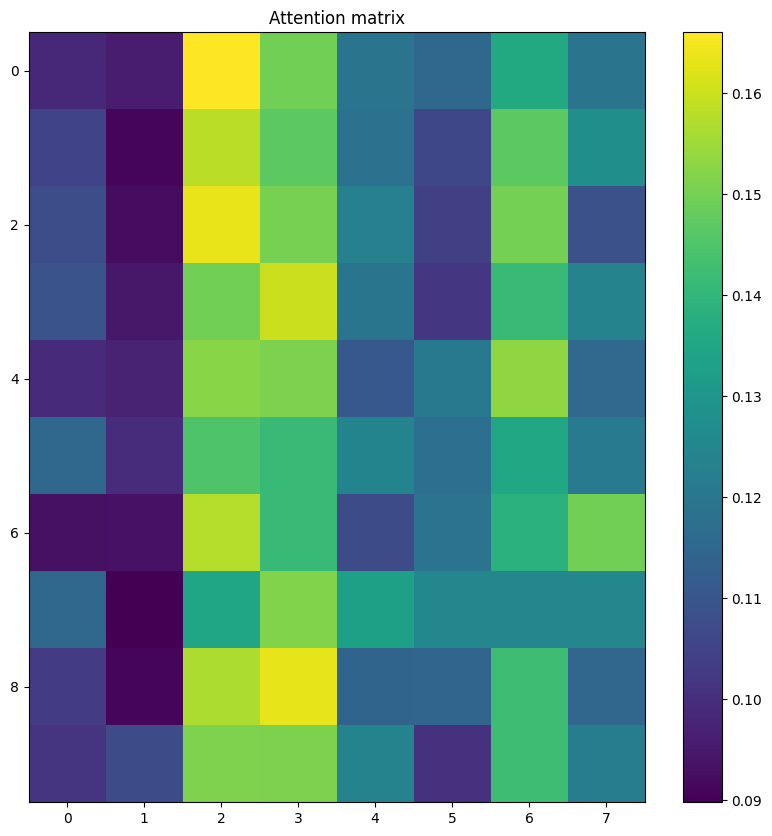

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Attention matrix')
plt.imshow(A[0])
plt.colorbar()

In this image attention, distribution should be almost uniform as we randomly initialize all elements, and the attention coefficient should be similar for all elements.

The last step is to use attention weights to compute the weighted sum of values. Sum each value with coefficient taken from the attention matrix.

\begin{align}
 O_k = \sum^n_{i = 1} a_{k i} v_i = A_k V
\end{align}
 where k - is a number of attention output

In [ ]:
## imagine that we have 10 queries and 8 keys and need to construce matrix of cofficent.

torch.manual_seed(6)
d = 64
t,k = 10, 8
batch_size = 3
query = torch.rand(batch_size, t, d)
key = torch.rand(batch_size, k, d)
value = torch.rand(batch_size, k, d)

def attention(query, key, value, d):
    coefficient_matrix = compute_coefficient_matrix(query, key, d)
    attention_matrix = torch.softmax(coefficient_matrix, dim=-1)
    out = attention_matrix @ value
    return attention_matrix, out


A, out = attention(query, key, value, d)
assert out.shape == query.shape
assert torch.allclose(out.sum(), torch.tensor(973.154541015625))

### Attention layer
To help attention find interesting patterns in data, we use linear projections to create queries, keys and values. A model can train such a projection matrix and describe data in the best way to solve the problem.

\begin{align}
q = w_q x_q + b_q \\
k = w_k x_k + b_k \\
v = w_v x_v + b_v \\
\end{align}
where $ w_q, w_k, w_v \in R^{n,n}$

The following steps are the same with attention.

#### task 3. Implement attention layer

In [ ]:
class AttentionLayer(torch.nn.Module):
    def __init__(self, d):
        super().__init__()
        self.q_layer = torch.nn.Linear(d, d) ## TODO trainiable projection layer
        self.k_layer = torch.nn.Linear(d, d) ## TODO trainiable projection layer
        self.v_layer = torch.nn.Linear(d, d) ## TODO trainiable projection layer
        self.d = d

    def forward(self, query_data, key_data, value_data):
        self.q_proj = self.q_layer(query_data)
        self.k_proj = self.k_layer(key_data)
        self.v_proj = self.v_layer(value_data)

        self.A, out = attention(self.q_proj, self.k_proj, self.v_proj, self.d)
        return out

d = 32
t, k = 10, 8
batch_size = 3
query_data = torch.rand(batch_size, t, d) # batch_size x seq_len x feature_size
key_data = torch.rand(batch_size, k, d) # batch_size x seq_len x feature_size
value_data = torch.rand(batch_size, k, d) # batch_size x seq_len x feature_size


att_layer = AttentionLayer(d)
att_layer_output = att_layer(query_data, key_data, value_data)

assert att_layer_output.shape == query_data.shape
assert not torch.allclose(attention(query_data, key_data, value_data, d)[1], att_layer_output)

### Self-attention
Attention mechanism does not suggest any restriction for input data, and a large number of modern architectures use attention when all $x_q, x_k, x_v$ the same input data. In this case query, key, the value produced by the same source but after application of trainable projection matrix represent data from a different point of view.


\begin{align}
 x_q = x_k = x_v = x
\end{align}

\begin{align}
q = w_q x \\
k = w_k x \\
v = w_v x \\
\end{align}

In [ ]:
d = 32
t = 10
batch_size = 3
x = torch.rand(batch_size, t, d)

att_layer = AttentionLayer(d)
att_layer_output = att_layer(x, x, x)

# Let's train models!

Let's consider toy examples to see how the attention mechanism work.
Our dataset is a sequence where each object represents a real number and flag. Our task is to find the sum of elements where the flag equals 1.

In [ ]:
def generate_dataset(seq_len, sample_count, target_elements_per_seq=3):
    marker = torch.zeros(sample_count, seq_len)
    for i in range(sample_count):
        # select random positions for markers
        pos = np.random.permutation(np.arange(seq_len))[:target_elements_per_seq]
        marker[i][pos] = 1.
    scaler = 10
    number = torch.rand(sample_count, seq_len) * scaler - scaler / 2
    y = (number * marker).sum(axis=1)
    x = torch.stack((number, marker), dim=-1)
    return x, y


In [ ]:
## generating data
## [
##    (x_1, flag_1), (x_2, flag_2) ... (x_n, flag_n)
## ]
x, y = generate_dataset(20, 10000)

#### task 4. provide train_test_split

In [ ]:
## split data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [ ]:
## constructing train and validation
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

batch_size_train = 32
batch_size_test = 1024

train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_test, num_workers=2)

To construct keys and values, we use input data and then apply a projection matrix. We utilise one trainable query to filter our data (such construction equals a row of attention matrix). Then we compute attention between all keys and one query with attention layer and use the obtained coefficient to make a weighted sum of values.

In [ ]:
class SummationAttentionModel(torch.nn.Module):
    def __init__(self, attention_layer, d):
        super().__init__()

        ## trainiable query
        self.syntetic_query = torch.nn.Parameter(torch.rand(1, 1, d))

        ## init layer for attention operation
        self.attention_layer = attention_layer

        ## we have one q in R^(d) -> output R^(d)
        ## linear layer map it in single output
        self.output_layer = torch.nn.Linear(d, 1)

    def forward(self, x):
        ## make attention between syntetic_query and x
        out = self.attention_layer(self.syntetic_query, x, x)

        ## out shape [n, 1, d] -> remove one dimension
        out = out[:, 0, :]

        ##  [n, d] -> [n, 1] for solving regression task
        prediction = self.output_layer(out)[:, 0]
        return prediction

In [ ]:
d = 2
## init model for our dataset with dimension size == 2
attention_layer = AttentionLayer(d)
model = SummationAttentionModel(attention_layer, d)

In [ ]:
## model use MSE loss with adam optimizer with default parameters
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.MSELoss()

In [ ]:
model.train()
losses_by_epoch = []
## train model during 50 epochs
for epoch in tqdm(range(50)):
    epoch_loss = []
    for batch in train_dataloader:
        x, y = batch
        ## take input data and target
        pred = model(x)
        ## compute loss function and calculate gradients
        loss = criterion(y, pred)
        loss.backward()

        ## weights update
        optimizer.step()
        optimizer.zero_grad()

        ## store loss for future plots
        epoch_loss.append(loss.detach().item())
    losses_by_epoch.append(np.mean(epoch_loss))


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss during epoch should decrease

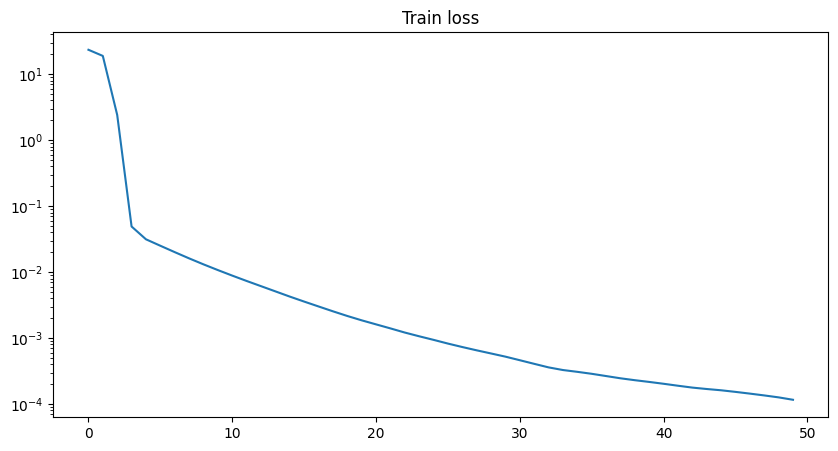

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Train loss')
plt.yscale('log')
plt.plot(losses_by_epoch);

Attention visualization

In [ ]:
model.eval()
batch = next(iter(test_dataloader))
x, y = batch
pred = model(x)

## save attention matrix for validation examples
valid_attention = model.attention_layer.A.detach().numpy()[:, 0]

k = model.attention_layer.k_proj.detach().numpy()
v = model.attention_layer.v_proj.detach().numpy()
q = model.attention_layer.q_proj.detach().numpy()

In [ ]:
x.shape

torch.Size([1024, 20, 2])

Queries for target elements should be a closer query with respect to the zero point to make the scalar product bigger.

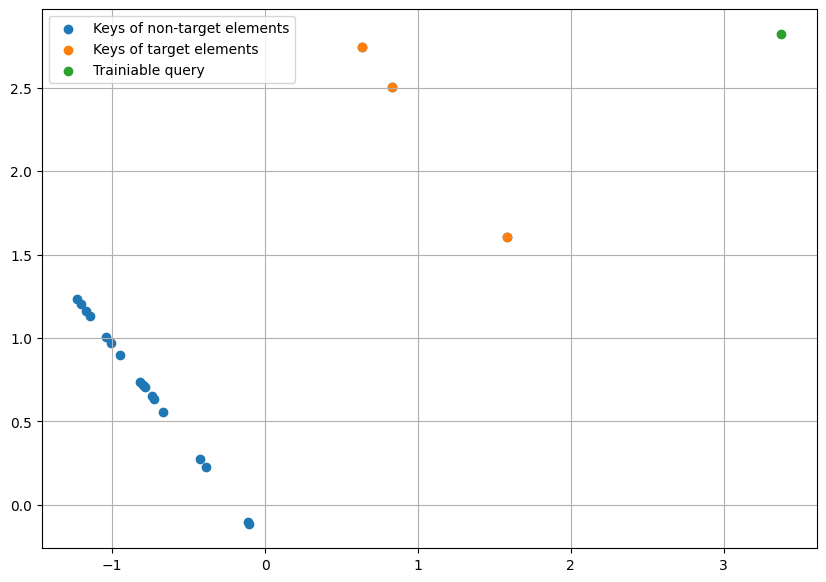

In [ ]:
idx = 5 # object ID
idx_of_target_examples = np.where(x[idx][:, 1] == 1)[0]

plt.figure(figsize=(10,7))

plt.scatter(k[idx, :, 0], k[idx, :, 1], label='Keys of non-target elements')
plt.scatter(k[idx, idx_of_target_examples, 0], k[idx, idx_of_target_examples, 1], label='Keys of target elements')
plt.scatter(q[0, :, 0], q[0, :, 1], label='Trainiable query')

plt.grid()
plt.legend()
plt.show()

The attention of query is close to zero for non-marked elements in a sequence, but considerable attention equals 1/3 because of softmax normalization.

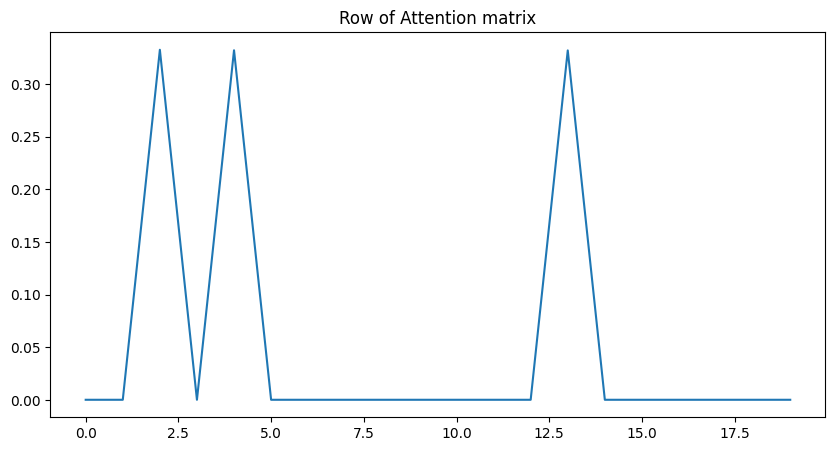

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Row of Attention matrix')
plt.plot(valid_attention[idx])

For different examples, the situation is the same. There are three peaks for each sequence that corresponds to the marked objects.

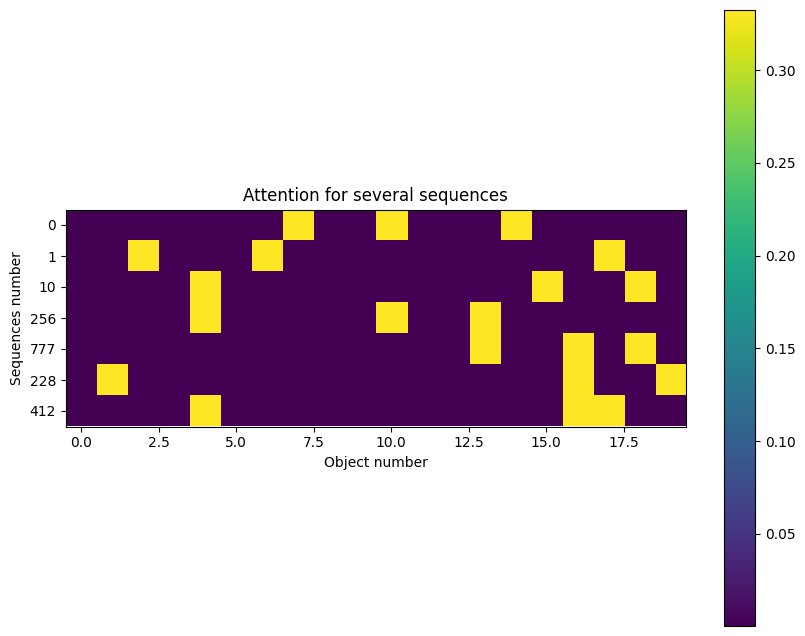

In [ ]:
## attention of differernt examples
idxes = [0, 1, 10, 256, 777, 228, 412]

plt.figure(figsize=(10,8))
plt.title('Attention for several sequences')
plt.yticks(range(len(idxes)), labels=idxes)
plt.ylabel('Sequences number')
plt.xlabel('Object number')

plt.imshow(valid_attention[idxes])

plt.colorbar()

### Masked attention

There are many datasets where sequence length is different in real life, but we still need batch processing to make a model work fast and efficient. For this purpose, we use padding for a sequence.

![padded_sequence.png](https://raw.githubusercontent.com/zaaabik/msd2021/main/padded_sequence.png)

Our task is to create a model that pushes the model to ignore padding elements and make attention for them equal to zero.

![masked_non_masked_attention.png](https://raw.githubusercontent.com/zaaabik/msd2021/main/masked_non_masked_attention.png)

Your task is:


1.   Pad keys and values using
`torch.nn.utils.rnn.pad_sequence(sequences, batch_first=False, padding_value=0.0)`. **Use parameter batch_first=True, to make output compatible with our attention function**
2.   Create a mask for keys and values, which help you make zeros in the attention matrix. To change the number in the attention matrix, you can use
`Tensor.masked_fill_(mask, value). This function takes Tensor and boolean masks with the same shape and then fills tensor elements with value parameters where the mask is True.



In [ ]:
def masked_attention(query, key, value, mask, d):
    coefficient_matrix = compute_coefficient_matrix(query, key, d)

    ## TODO: make an masked attention
    if mask is not None:
        print(mask)
        coefficient_matrix = coefficient_matrix.masked_fill(
            mask == 0, float("-1e20")
        )
    attention_matrix = torch.softmax(coefficient_matrix, dim=-1)

    out = attention_matrix @ value
    return attention_matrix, out


In [ ]:
class MaskedAttentionLayer(torch.nn.Module):
    def __init__(self, d):
        super().__init__()
        self.q_layer = torch.nn.Linear(d, d)
        self.k_layer = torch.nn.Linear(d, d)
        self.v_layer = torch.nn.Linear(d, d)
        self.d = d

    def forward(self, query_data, key_data, value_data, mask=None):
        self.q_proj = self.q_layer(query_data)
        self.k_proj = self.k_layer(key_data)
        self.v_proj = self.v_layer(value_data)

        self.A, out = masked_attention(self.q_proj, self.k_proj, self.v_proj, mask, self.d)
        return out

d = 32
t, k = 10, 8
batch_size = 3
query_data = torch.rand(batch_size, t, d) # batch_size x seq_len x feature_size
key_data = torch.rand(batch_size, k, d) # batch_size x seq_len x feature_size
value_data = torch.rand(batch_size, k, d) # batch_size x seq_len x feature_size

mask = torch.tril(torch.ones((t, t))).expand(
            batch_size, 1, t, t
)

att_layer = MaskedAttentionLayer(d)
att_layer_output = att_layer(query_data, key_data, value_data)

assert att_layer_output.shape == query_data.shape
assert not torch.allclose(attention(query_data, key_data, value_data, d)[1], att_layer_output)

## Evaluate real transformer!

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List

# We need to modify the URLs for the dataset since the links to the original dataset are broken
# Refer to https://github.com/pytorch/text/issues/1756#issuecomment-1163664163 for more info
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

# choose languages of translation
source_language = 'de'
target_language = 'en'

token_transform = {}
vocab_transform = {}

In [ ]:
# Get two tokenizers for different languages
token_transform[source_language] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[target_language] = get_tokenizer('spacy', language='en_core_web_sm')

def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {source_language: 0, target_language: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Special Tokens
UNK_IDX = 0  # Token for unknown word
PAD_IDX = 1  # Padding token
SOS_IDX = 2  # Start Of Sequence token
EOS_IDX = 3  # End Of Sequence token

# Define special tokens
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

# Create a vocabulary for each language containing all words and tokens
for ln in [source_language, target_language]:
    train_iter = Multi30k(
        split='train',
        language_pair=(source_language, target_language)
    )

    vocab_transform[ln] = build_vocab_from_iterator(
        yield_tokens(train_iter, ln),
        min_freq=1,
        specials=special_symbols,
        special_first=True
    )

# Specify how to handle unknown words (replace them with <unk>)
for ln in [source_language, target_language]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [ ]:
token_transform['en']('i like cats and dogs,')

['i', 'like', 'cats', 'and', 'dogs', ',']

In [ ]:
vocab_transform

{'de': Vocab(), 'en': Vocab()}

#### Creating transformer model

##### embeddings blocks

In [ ]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)

    def forward(self, x):
        out = self.embedding(x)
        return out

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(
            self,
            emb_size: int,
            dropout: float,
            maxlen: int = 5000
        ):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2) * np.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

In [ ]:
# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(
            d_model=emb_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )

        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(
            self,
            src,
            trg,
            src_mask,
            tgt_mask,
            src_padding_mask,
            tgt_padding_mask,
            memory_key_padding_mask
        ):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src, src_mask):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt, memory, tgt_mask):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

### Training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=device).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[source_language])
TGT_VOCAB_SIZE = len(vocab_transform[target_language])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(
    NUM_ENCODER_LAYERS,
    NUM_DECODER_LAYERS,
    EMB_SIZE,
    NHEAD,
    SRC_VOCAB_SIZE,
    TGT_VOCAB_SIZE,
    FFN_HID_DIM
)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([SOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [source_language, target_language]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[source_language](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[target_language](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [ ]:
from torch.utils.data import DataLoader

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = Multi30k(split='train', language_pair=(source_language, target_language))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))


@torch.no_grad()
def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(source_language, target_language))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

In [ ]:
from timeit import default_timer as timer
n_epochs = 8

for epoch in range(1, n_epochs + 1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 1, Train loss: 3.369, Val loss: 3.437, Epoch time = 43.855s
Epoch: 2, Train loss: 3.255, Val loss: 3.338, Epoch time = 43.525s
Epoch: 3, Train loss: 3.148, Val loss: 3.246, Epoch time = 44.195s
Epoch: 4, Train loss: 3.050, Val loss: 3.176, Epoch time = 44.188s
Epoch: 5, Train loss: 2.954, Val loss: 3.090, Epoch time = 43.941s
Epoch: 6, Train loss: 2.862, Val loss: 3.011, Epoch time = 43.559s
Epoch: 7, Train loss: 2.780, Val loss: 2.929, Epoch time = 43.740s
Epoch: 8, Train loss: 2.690, Val loss: 2.845, Epoch time = 43.613s


### Inference

In [ ]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
@torch.no_grad()
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[source_language](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=SOS_IDX).flatten()
    return " ".join(vocab_transform[target_language].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [ ]:
src = "Eine Gruppe von Menschen steht vor einem Iglu ."
print(translate(transformer, src))

<sos> A group of people are playing a table . 


![igloo.jpg](https://raw.githubusercontent.com/zaaabik/msd2021/main/igloo.jpg)

In [ ]:
src = 'Mann im schwarzen Anzug geht zur Bushaltestelle'
print(translate(transformer, src))

<sos> A young man is playing a bicycle . 


![men_in_black_3_still.jpg](https://raw.githubusercontent.com/zaaabik/msd2021/main/men_in_black_3_still.jpg)

## Summary

*   Query, key helps the model find a relevant object in a sequence + interpretable.
*   Computing attention matrix in a vectorize form significant improve the speed.
*   For batch processing with sequences with different lengths, masked attention should be used.
*   There are several functions used as the score function.